In [1]:
#Using the MNIST data set to experiment with Classification exercises

In [2]:
#this code fetches the MNIST dataset
#DESCR = key describing the dataset
#data = array with one row per instance and one column per feature
#target = array with the labels

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
#looking at these arrays, there are 70,000 images, and each has 784 features (28x28 pixels)

X, y = mnist["data"], mnist["target"]
print("X shape: ", X.shape)
print("X shape: ",y.shape)

X shape:  (70000, 784)
X shape:  (70000,)


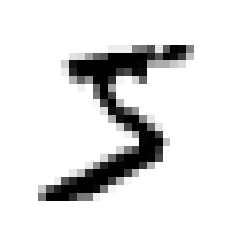

In [4]:
#look at 1 digit from the dataset: '
#grab an instance's feature vector, 
#reshape it to a 28x28 array, and
#and display the plot

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [5]:
#show the corresponding label

y[0]

'5'

In [6]:
#This label is currently a string, however, ML uses numbers, therefore lets cast 'y' to an integer

import numpy as np
y = y.astype(np.uint8)

In [7]:
#we need to create the test set to set aside for inspection later
#good to know that MNIST is already split into a training set (first 60,000 images), and test set (last 10,000 images)

X_train, X_test, y_train, y_test = X[:60000], X[:60000], y[:60000],y[:60000]

In [8]:
#creating a 'binary classifier' for 5, to distinguish between two classes, 5 and not 5

y_train_5 = (y_train == 5) #true for all 5s, and false for all other digits
y_test_5 = (y_test == 5)

In [9]:
#picking a classifier to train, the 'Stochastic Gradient Descent (SGD)'
#good for large datasets, trains instances independently (one at a time), and is good for online learning

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
#now we can use to detect images of number 5
#true output means that the predicted result matches the actual label image

sgd_clf.predict([some_digit])

array([ True])

In [11]:
#Performance Measures

In [12]:
#we can meaure accuracy using cross-validation (just like chapter 2)
#the code mimics Scikit-learn's 'cross_val_score()' function
#StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class
#at each iteration, code creates a clone of each classifier, trains that clone on training folds, and make prediction on test fold
#then counts number of correct predictions and outputs ratio of correct predictions
#produces over 91% accuracy!

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_test[test_index]
    y_test_folds = y_test_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))


0.9669
0.91625
0.96785


In [13]:
#NOW use the 'cross_val_score()' to evaluate/compare to SGDClassifier model
#split training set into K folds
#make predictions and evaluate them on each fold using a model trained on remaining folds
#produces over 95% accuracy!

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
#The accuracy looks really good, but lets look at a very dumb classifier that just classifies every single image in the "not-5" class
#produces over 90% accuracy!
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

#now guess the model accuracy

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [15]:
# note tho, that about 10% of the dataset are 5's therefore, if we were to guess, we should be right about 90% of the time
# this demonstrates why accuracy is not preferred performance measure for classifiers, especially for 'skewed datasets'

In [16]:
#create a 'confusion matrix' to evaluate the performance of a classification problem
#performs k-fold cross-validation, but returns the predictions made to each test fold

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
#now access the confusion matrix, passing the target class (y_train_5) and predicted classes (y_train_pred)
#row = actual class
#column = predicted class
#1st row = non-5 images (53892 of them correctly classified as non-5s, true negative), remaining 687 were wrongly classified as 5s (false positive)
#2nd row = images of 5s, 1891 wrongly classified by non-5s (false negative), remaining 3530 correctly classified as 5s (true positive)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [18]:
#displaying diagonal confusion matrix

y_train_perfect_predictions = y_train_5 #pretent we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [19]:
#showing results in concise manner, we will look at the model 'precision': accuracy of positive predictions
#precision = TP/(TP+FP)
#also helful to calculate the system sensitivity (or true positive rate or recall): ratio of positive instances that are correctly detected by classifier
#sensitivity = TP/(TP+FN)

from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) #== 3520/(3520+687)
recall_score(y_train_5, y_train_pred) #== 3520/(3520+1891)

0.6511713705958311

In [20]:
#combine precision and recall into a single metric called the F1_score (harmonic mean)
#this metric gives much larger weight to small values, so in order to get high F1, both precision AND recall must be high
#F1 = 2/((1/precision)+(1/recall)) = 2*((precision*recall)/(precision+recall)) = TP/(TP + (FN+FP)/2)
#F1 favours classifiers that have similar precision & recall

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [21]:
#use the following function to return score for each instance, 
#then use chosen threshold (0) to make predictions based on these scores
#true = returns same results as predicted, false = doesn't match predictions based on threshold

y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
#now we need to find the appropriate threshold to use
#first use 'cross_val_predict()' to get scores of all instancesin training set (now must be returned as decision scores)

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

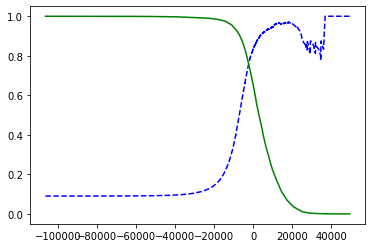

In [23]:
#from these scores, now use following function to compute precision and recall for ALL possible thresholds
#input training data and y_scores from above, and plot precision and recall curves vs the array of threshold values

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [24]:
#refining threshold further, search for lowest threshold that gives as least 90% precision

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [25]:
#for now lets just use the 'predict()'

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [26]:
#check predictions precision and recall
precision_score(y_train_5, y_train_pred_90) #0.900038
recall_score(y_train_5, y_train_pred_90) #0.4368

0.4799852425751706

In [27]:
#plot the receiver operating characteristic (ROC) curve - which is Sensitivity (recall) vs 1-specificity

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

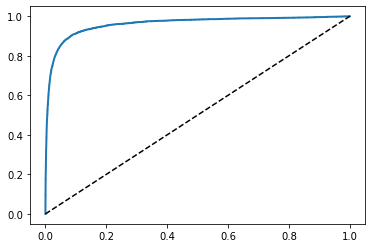

In [28]:
#now plot FRP vs TRP

def plot_roc_curve(fpr,tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--') #dashed diagonal
    
plot_roc_curve(fpr,tpr)
plt.show()

In [29]:
#computing ROC area under the curve (AUC); perfect model, AUC=1

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [30]:
#training 'RandomForestClassifier' to compare ROC curve and ROC AUC to those of SGDClassifier

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [31]:
#for roc_curve() we will pass it class probabilities as the score

y_scores_forest = y_probas_forest[:,1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

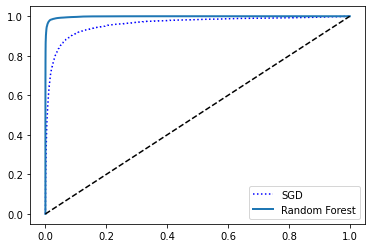

In [32]:
#plot the ROC curve
#shows that random forest classifier is superior to SGD, b/c ROC curve is much closer to top-left corner, and greater AUC
plt.plot(fpr,tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()

In [33]:
#output ROC AUC

roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [34]:
#Now looking into multiclass calssification
#One-vs-the rest (OvR)
#One-vs-One (OvO)

In [35]:
#try this on a Support Vector Machine Classifier

from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) #y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [36]:
#calling the decision_function() we get back 10 scores per instance (1 score per class)

some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [37]:
#highest score corresponds to '5'

np.argmax(some_digit_scores)
svm_clf.classes_
svm_clf.classes_[5]

5

In [38]:
#forcing to use OvR or OvO specifically

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [39]:
#training the SGDClassifier

sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [40]:
#look at the score that SGD classifier assigned to each class
#the model is pretty confident with most classes, other than class_3, therefore we need to narrow in on this
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [41]:
#looking deeper at class_3, we will evaluate the classifier using cross-validation
#pretty good values (>84%)
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [42]:
#but for better accuracy lets scale the inputs

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled, y_train,cv=3,scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [43]:
#Error Analysis

In [44]:
#first, look at confusion matrix: make predictions using cross-val and then call confusion matrix

y_train_pred = cross_val_predict(sgd_clf,X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

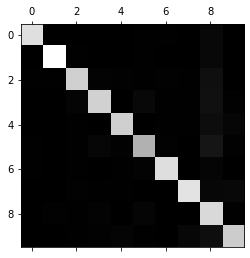

In [45]:
#too many numbers, so lets look at an image representation
#most images are on the main diagonal, meaning they were classified correctly

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [46]:
#now lets look the errors
#divide each value of conf_mx by number of images in corresponding class to compare error rates instead of absolute # of errors

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

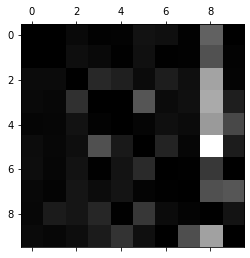

In [47]:
#fill diagonal with zeros to keep ONLY the errors

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [48]:
 # EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

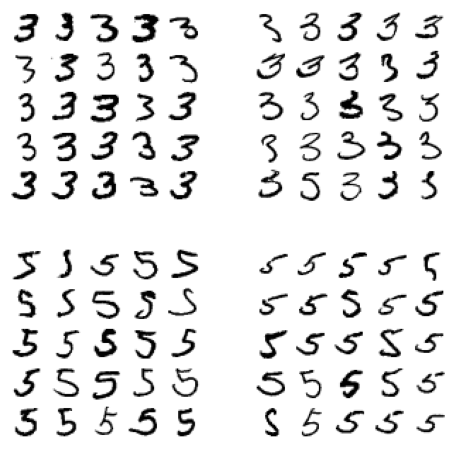

In [49]:
#plotting examples of 3s and 5s

cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [50]:
#multilabel classification
#outputs multiple binary tags
#creates two target labels: 1. is it 7,8,9, 2. is it odd

from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier()

In [51]:
#make a prediction and outputs two labels
#correct! 5 is not large, and it is odd
knn_clf.predict([some_digit])

array([[False,  True]])

In [52]:
#to evaluate the multilabel class, we will use F1_score for each label and then compute average score
#this model assumes equal weighting to each label (average = "macro")
#to give more weight to a certain label (average = "weighted")
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [53]:
#Multioutput Classification
#generalization of multilabel class. where each label can be multiclass (ie, can have >2 possible values)

In [54]:
# for us, 
#1. we will use to input noisy digit image
#2. output a clean digit image
#3. represented as an array of pixel intensities

In [55]:
#start by creating test sets by taking MNIST images and adding noise to their pixel intensities
#target images are the original images

noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [56]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

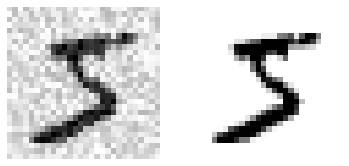

In [57]:
#not included in book (found in soln manual), but needed to create 'some_index' variable
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

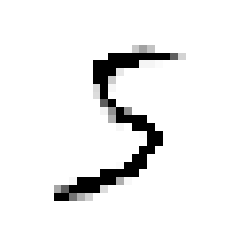

In [58]:
#now, train the classifier and make it clean this image

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

In [59]:
# Exercise Problems

In [60]:
#Q1: build classifier for MNIST with 97% accuracy on test set

from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_neighbors=3, weights=uniform, score=0.972, total=12.6min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.6min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.971, total=12.6min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 25.3min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=12.5min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=12.6min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.970, total=12.7min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=12.6min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=12.6min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=12.6min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=12.8min
[CV] n_neighbors=3, weights=distance .................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 401.5min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [63]:
#outputting the best hyperparameter

grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [64]:
#resulting in the best score

grid_search.best_score_

0.9716166666666666

In [65]:
#finally, calculate the classifiers accuracy

from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

In [66]:
#Q2: build function to shift MNIST image in any direction (LRTD) by on pixel
#for each image in training set, create 4 shifted copies & add to training set.
#test model on training set and measure its accuracy on test set.
#** model should perform even better now as a result of 'data augmentation'

In [67]:
#importing image shifting function

from scipy.ndimage.interpolation import shift

In [68]:
#defining image shifting function

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

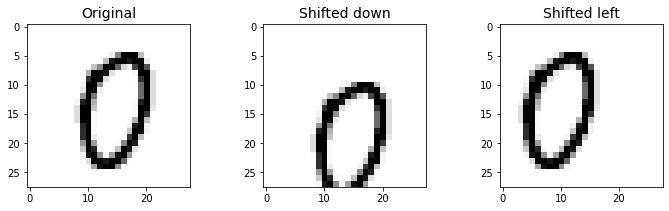

In [69]:
#using the X_train array, demonstrating how shift_image function defined above shifts the image
#1st figure = original
#2nd figure = shift image down 5 units
#3rd figure = shift image left 5 units

image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [70]:
#creating 4 shifted copies of the training set (1 per direction) and add to training set

X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [71]:
#grabbing random index value within the augmented training set (X_train_augmented) to perform shift

shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [72]:
#using K-fold classifier to train model

knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [73]:
#fit the data

knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [74]:
#predict value and output the accuracy_score
#NOTE: simply augmenting model gives a boost of 0.5% accuracy

y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

In [75]:
#Q3: Tackle Titanic dataset (from Kaggle.com/c/titanic)
#with goal being to predict whether passenger survived based on age, sex, passenger class, ...

In [76]:
#first we dowloaded ALL data files from Kaggler and uploaded to Jupyter notebook under ($ML_PATH/datasets/Titanic)
#now we need to load the data

import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [77]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [78]:
#splitting data into training set and test set

train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [79]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [80]:
#get more info and see how much data is missing
#cabin is missing a lot of data so we will just exclude
#and for the rest we will have to decide what to replace empty cell with (NaN, 0, median, ...)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [81]:
#lets look at the numerical data

train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [82]:
#check to see if the target is indeed 0 or 1

train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [83]:
#take a look at categorical data

train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [84]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [85]:
#Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton

train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [86]:
#re-use the DataFrameSelector we built in the previous chapter to select specific attributes from DataFrame

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [87]:
#build a pipeline for the numerical attributes

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [88]:
#fit and tranform the training data
#created array where row given for each passenger and column for each attribute

num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [89]:
#also need an imputer for string categorical attributes
# Inspired from stackoverflow.com/questions/25239958

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [90]:
from sklearn.preprocessing import OneHotEncoder

In [91]:
#now build pipeline for categorical attributes

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [92]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [93]:
#join numerical and categorical pipelines

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [94]:
#now we have a preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to the ML model

X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [95]:
#labeling the data 'survived' because the true case (1) represented those who survived

y_train = train_data["Survived"]

In [96]:
#now ready to train the classifier
#first going to use a simple SVC

from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

In [97]:
#now lets use the trained model to make predictions on the test set

X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

In [98]:
#lets use cross-validation to to evaluate our model

from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

In [99]:
#lets improve the score by using a random forest classifier


from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

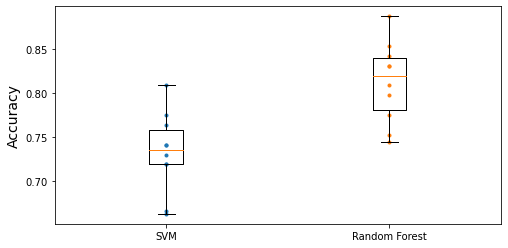

In [100]:
#now rather than just averaging the scores over 10 CV folds, lets plot all 10 scores using box plotting

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [101]:
#to improve score there are many modifications we can make to the data
#eg. below we create an age bucket

train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [102]:
#similarly, create a bucket for passengers travelling alone

train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [104]:
#Q4: Building a spam classifier

In [105]:
#start off by fetching the data
#download the examples of spam and ham from Apache SpamAssassin's public dataset
#unzip data and familiarize yourself with data format

import os
import tarfile
import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [106]:
fetch_spam_data()

In [107]:
#load all of the emails

HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [108]:
len(ham_filenames)

2500

In [109]:
len(spam_filenames)

500

In [110]:
#using pythons 'email' module to parse these emails

import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [111]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [112]:
#looking at an example of ham to get a feel of what the data looks like

print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [113]:
#looking at an example of spam to get a feel of what the data looks like

print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


In [114]:
#some emails can be multipart, with images and attachments, let look at the various types of structures we have

def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [115]:
#creating an incrementing counter for each time an email has multipart structure
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [116]:
#structure of ham emails

structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [117]:
#structure of spam emails

structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [118]:
#NOTE: seems that ham emails are more often plain text structure
#but, spam has fairly equal part plain text AND html
#a number of ham emails are signed using PGP, while not the case in spam emails

In [119]:
#take a look at the email headers
#lots of useful information in here, but we might need to narrow down our scope a bit
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [120]:
#narrow down scope by looking at 'Subject' header only


spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

In [121]:
#Now lets split data into training set and test set

import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
#now create preprocessing preparation pipeline
#will have to,
#             convert each email into a feature vector
#             tranform an email into a sparse vector that indicates presence or absence of each possible word

In [123]:
#first lets convert HTML to plain text
#BEST way to do this is to use 'BeautifulSoup' library, but we will simplify and create our own soln,
#It will drop <head> section, convert all <a> tags to the word HYPERLINK, then gets rid of HTML tags, leaving ONLY plain text
#also replaces multiple newlines with single newline, and finally unescapes html entities

import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I) #drop all <head> sections
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I) #convert all <a> tags to the word HYPERLINK
    text = re.sub('<.*?>', '', text, flags=re.M | re.S) #gets rid of HTML tags, leaving only plain text
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S) #replaces multiple newlines with single newlines
    return unescape(text)

In [124]:
#see if it works with spam emails

html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [125]:
#this is the resulting plain text

print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [126]:
#write function that takes an email as input and returns its content as plain text, no matter the format

def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [127]:
#use the above functions on sample email

print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


In [128]:
#we now want to add some hyperparameters to preparation pipeline to control: 
#     whether or not to strip off email headers
#     convert each email to lowercase
#     remove punctuation, replace all URLs with 'URL', replace all numbers with 'NUMBERS'
#     or perform stemming (i.e., trim off word endings)

In [129]:
#now lets throw in some stemming (we will need to install Natural Language Toolkit - NLTK)

try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [130]:
#now we will convert URLs to the word "URL" using the library 'urlextract'
# if running this notebook on Colab, we just pip install urlextract

try:
    import google.colab
    !pip install -q -U urlextract
except ImportError:
    pass # not running on Colab

In [131]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

Error: replacing URLs requires the urlextract module.


In [132]:
#put it all together into a transformer that is used to convert emails to word counters
#we will split sentences into words using 'split()', using white space for word boundaries


from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [133]:
#try transforming a couple of emails

X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'http': 1, 'www': 1, 'postfun': 1, 'com': 1, 'pfp': 1, 'worboi': 1, 'html': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 're

In [134]:
#now that we have the word counts, we need to convert them into vectors
#we will build a new transformer that builds a vocabulary (ordered list of common words)
#and will transform() will use vocabulary to convert word counts to vectors
#output is a sparse matrix

from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [135]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.intc'>'
	with 20 stored elements in Compressed Sparse Row format>

In [136]:
#looking at second row:
#     99 = 99 words that are not part of the vocabulary 
#     11 = first word in the vocabulary is presented 11 times in the email ('the')
#     9  = second word in vocabulary is presented 9 times, etc  ('of')

X_few_vectors.toarray()

array([[  6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [112,  11,   9,   8,   3,   1,   0,   1,   3,   0,   1],
       [ 92,   0,   1,   2,   3,   4,   5,   3,   1,   4,   2]],
      dtype=int32)

In [137]:
#the matrix above can be seen visually

vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'http': 5,
 'number': 6,
 'com': 7,
 'all': 8,
 'yahoo': 9,
 'in': 10}

In [138]:
#now lets train the spam classifier

from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [139]:
#determining the accuracy score
#note, we use the 'lbfgs' solver so that this model can be used in the future
#pretty impressive results, however we are testing on an 'easy' dataset.
#if we tested on a 'harder' dataset, it will not do nearly as well. So it would take some tinkering to find the best model
#but we will leave as is for today

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.983, total=   0.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... , score=0.984, total=   0.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] .................................... , score=0.993, total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s finished


0.9862500000000001

In [140]:
#outputting the precision/recall for the test set

from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 96.88%
Recall: 97.89%
